# DSCI 100  Project Final Report 

**Group 26** \
// TODO: put other names here

Dian Ping \#79047692 \
Matt Wiens \#21158845

In [73]:
import itertools
import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [74]:
# Simplify working with large datasets in Altair
alt.data_transformers.enable("vegafusion")

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [75]:
# Seed for sklearn random_state parameter
SEED = 1234

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC hosts a Minecraft server, PLAICraft. The project lead of PLAICraft, Frank Wood, is interested in answering the following question:

> "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

This report will investigate the first part of that question through analysis of data obtained from players’ gameplay sessions and user registration information. The general idea of what we will do is find features—either the variables directly included in the data or transformations of them—which help us predict player newsletter subscription status. 

### Data description

We'll first load the data and then describe it.

In [76]:
players = pd.read_csv("data/players.csv")
sessions = pd.read_csv("data/sessions.csv")

In [77]:
players

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,Morgan,Male,9,NaN,NaN
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,Christian,Male,17,NaN,NaN
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,Blake,Male,17,NaN,NaN
3,Amateur,True,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,Flora,Female,21,NaN,NaN
4,Regular,True,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,Kylie,Male,21,NaN,NaN
...,...,...,...,...,...,...,...,...,...
191,Amateur,True,b6e9e593b9ec51c5e335457341c324c34a2239531e1890...,0.0,Bailey,Female,17,NaN,NaN
192,Veteran,False,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778...,0.3,Pascal,Male,22,NaN,NaN
193,Amateur,False,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db29...,0.0,Dylan,Prefer not to say,17,NaN,NaN
194,Amateur,False,f19e136ddde68f365afc860c725ccff54307dedd13968e...,2.3,Harlow,Male,17,NaN,NaN


In [78]:
sessions

,hashedEmail,start_time,end_time,original_start_time,original_end_time
0,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,30/06/2024 18:12,30/06/2024 18:24,1.719770e+12,1.719770e+12
1,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,17/06/2024 23:33,17/06/2024 23:46,1.718670e+12,1.718670e+12
2,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3...,25/07/2024 17:34,25/07/2024 17:57,1.721930e+12,1.721930e+12
3,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,25/07/2024 03:22,25/07/2024 03:58,1.721880e+12,1.721880e+12
4,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,25/05/2024 16:01,25/05/2024 16:12,1.716650e+12,1.716650e+12
...,...,...,...,...,...
1530,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,10/05/2024 23:01,10/05/2024 23:07,1.715380e+12,1.715380e+12
1531,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e...,01/07/2024 04:08,01/07/2024 04:19,1.719810e+12,1.719810e+12
1532,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33...,28/07/2024 15:36,28/07/2024 15:57,1.722180e+12,1.722180e+12
1533,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33...,25/07/2024 06:15,25/07/2024 06:22,1.721890e+12,1.721890e+12


The `players` dataframe contains information about 196 players with the following 9 variables:

| Variable | Type | Description | Notes |
|---|---|---|---|
| experience | ordinal | Experience level  | Values have the following ordering:  Beginner, Amateur, Regular, Pro, Veteran |
| subscribe | boolean | Newsletter subscription status | &nbsp; |
| hashedEmail | string | Email (hashed) | Unique for each player and can be used to join the `sessions` dataframe (see below) |
| played_hours | numeric | Total gameplay hours | &nbsp; |
| name | string | First name | &nbsp; |
| gender | categorical | Gender | Gender includes more than two categories, e.g., Male, Female, Two-Spirited, Non-binary |
| age | numeric | Player's age | &nbsp; |
| individualId | unknown | Player's ID | No values included in the data |
| organizationName | unknown| Player's organization | No values included in the data |


The `sessions` dataframe contains information about 1535 gameplay sessions with the following 5 variables:

| Variable | Type | Description | Notes |
|---|---|---|---|
| hashedEmail | string | Player email (hashed) | Unique for each player and can be used to join the `players` dataframe |
| start_time | datetime (string) | Session start datetime | Stored as string in `DD/MM/YYYY HH:MM` format |
| end_time | datetime (string) | Session end datetime | Stored as string in `DD/MM/YYYY HH:MM` format |
| original_start_time | numeric | Session start datetime | Stored as Unix time in milliseconds |
| original_end_time | numeric | Session end datetime | Stored as Unix time in milliseconds |

#### Optional: discrepancies in the data

Before moving on to analysis, we want to highlight an important issue with the data: the `played_hours` from the `players` dataframe is not consistent with the total played hours from the `sessions` dataframe.

This section can be skipped, but note the main point: we must decide whether `played_hours` from `players` or the played hours computed from `sessions` reflects true gameplay hours. We have no way of determining which is correct, so this report arbitrarily treats the played hours from the `players` data as correct.

To explore how the played hours from the `players` dataframe compares with played hours computed from `sessions`, we perform the following operations:

+ compute each session's length
+ sum the lengths of all sessions for each player
+ merge this data with the gameplay hours column from `players`
+ filter to keep only the rows where the two gameplay hour columns are not equal
+ compute the absolute and relative difference between the columns

For both the absolute and relative difference we treat them as errors; that is, we consider only their magnitudes and ignore their signs. The relative difference is computed relative to the `played_hours` from the `players` data. Thus if $t$ represents time in hours, the relative difference is given by $$\frac{\lvert t_\text{players} - t_\text{sessions} \rvert}{t_\text{players}}.$$

In [79]:
DATE_FORMAT = "%d/%m/%Y %H:%M"
sessions_temp = sessions.copy()

# Convert session start time and end time columns to datetime objects
sessions_temp["start_time"] = pd.to_datetime(
    sessions_temp["start_time"], format=DATE_FORMAT
)
sessions_temp["end_time"] = pd.to_datetime(
    sessions_temp["end_time"], format=DATE_FORMAT
)

# Get each session length in hours
sessions_temp["session_length_hours"] = (
    sessions_temp["end_time"] - sessions_temp["start_time"]
).dt.total_seconds() / 3600

# Merge the two played hour columns by left joining on hashed email
hours_mismatch = players[["hashedEmail", "played_hours"]].merge(
    sessions_temp.groupby("hashedEmail").agg(
        played_hours_from_sessions=("session_length_hours", "sum"),
    ),
    on="hashedEmail",
    how="left",
)

# Fill any NaNs from the left join
hours_mismatch["played_hours_from_sessions"] = hours_mismatch[
    "played_hours_from_sessions"
].fillna(0)

# Filter by the two hours played columns not being equal
hours_mismatch = hours_mismatch[
    hours_mismatch["played_hours"] != hours_mismatch["played_hours_from_sessions"]
]

# Get the absolute and relative differences
hours_mismatch["hours_diff"] = (
    hours_mismatch["played_hours"] - hours_mismatch["played_hours_from_sessions"]
).abs()
hours_mismatch["rel_diff"] = (
    hours_mismatch["played_hours"] - hours_mismatch["played_hours_from_sessions"]
).abs() / hours_mismatch["played_hours"]

hours_mismatch

,hashedEmail,played_hours,played_hours_from_sessions,hours_diff,rel_diff
0,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,33.650000,3.350000,0.110561
1,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,4.250000,0.450000,0.118421
2,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,0.083333,0.083333,inf
3,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,0.833333,0.133333,0.190476
4,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,0.150000,0.050000,0.500000
...,...,...,...,...,...
186,ba24bebe588a34ac546f8559850c65bc90cd9d51b82158...,0.1,0.183333,0.083333,0.833333
192,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778...,0.3,0.350000,0.050000,0.166667
193,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db29...,0.0,0.083333,0.083333,inf
194,f19e136ddde68f365afc860c725ccff54307dedd13968e...,2.3,2.983333,0.683333,0.297101


We can see from the following histogram that absolute discrepancies are generally small but can be huge: most are under one hour, but several are over ten hours.

In [80]:
hours_diff_plot = (
    alt.Chart(hours_mismatch)
    .mark_bar()
    .encode(
        x=alt.X("hours_diff").bin(step=1).title("Time discrepancy (hours)"),
        y=alt.Y("count()").title("Counts"),
    )
    .properties(
        width=500,
        title="Histogram of Gameplay Hours Discrepancy (absolute)",
    )
)
hours_diff_plot

alt.Chart(...)

The next histogram shows the (finite) relative discrepancies: the majority are significant and many are huge.

Figure 1: Histogram of Gameplay Hours Discrepancy (absolute)

In [81]:
rel_diff_plot = (
    alt.Chart(hours_mismatch[hours_mismatch["rel_diff"] < np.inf])
    .mark_bar()
    .encode(
        x=alt.X("rel_diff")
        .bin(step=0.2)
        .title("Time discrepancy (fraction of gameplay hours from players data)"),
        y=alt.Y("count()").title("Counts"),
    )
    .properties(
        width=500,
        title="Histogram of Gameplay Hours Discrepancy (relative, finite only)",
    )
)
rel_diff_plot

alt.Chart(...)

Figure 2: Histogram of Gameplay Hours Discrepancy (relative, finite only)

If we're going to use gameplay hours in our analysis, we need to choose which source to use. Unfortunately, absent more information, the choice is completely arbitrary. For this report we'll choose to use the gameplay hours from the `players` dataframe.

This section also calls into question whether it's valid to combine *any* data from `players` and `sessions`. We take the position that it is valid, with the justification that the PLAI would not have provided data that are fundamentally incompatible (even if they are not error-free).

We now move back to the focus of this report and begin our analysis.

## Methods and Results

### Overview

We want to identify which features help predict player newsletter subscription status. To do this, we will find the combination of features that allow a $k$-nearest neighbours (KNN) classifier to achieve the highest predictive accuracy.

First, we will perform exploratory data analysis to understand the data and identify predictor features. Next, we will perform grid-search cross-validation using KNN, where the grid spans different combinations of predictors as well as the number of nearest neighbors used. The best-performing model from the grid will give us the combination of features that lead to the highest predictive accuracy.

###  Tidying and initial wrangling

The response variable we will predict is the `subscribe` variable from the `players` dataframe. The `players` dataframe gives us candidate predictor features `experience`, `played_hours`, `gender`, and `age`. We will also derive the following additional candidate predictor features from the `sessions` dataframe:

+ number of sessions
+ average session length

The below code obtains these features and combines them with the `players` columns. Important note: for players having no sessions, we fill in their average session length with 0, even though the true value is undefined.

In [82]:
# Convert session start time and end time columns to datetime objects
DATE_FORMAT = "%d/%m/%Y %H:%M"

sessions["start_time"] = pd.to_datetime(sessions["start_time"], format=DATE_FORMAT)
sessions["end_time"] = pd.to_datetime(sessions["end_time"], format=DATE_FORMAT)

# Get each session length in seconds
sessions["session_length"] = (
    sessions["end_time"] - sessions["start_time"]
).dt.total_seconds()

# Aggregate by hashed email
session_stats = (
    sessions.groupby("hashedEmail")
    .agg(
        num_sessions=("hashedEmail", "count"),
        avg_session_length_seconds=("session_length", "mean"),
    )
    .reset_index()
)

# Left join players with session stats on hashedEmail
players_combined_messy = players.merge(session_stats, on="hashedEmail", how="left")

# Fill in NaNs for players with 0 sessions
players_combined_messy["num_sessions"] = (
    players_combined_messy["num_sessions"].fillna(0).astype(int)
)
players_combined_messy["avg_session_length_seconds"] = players_combined_messy[
    "avg_session_length_seconds"
].fillna(0)


To tidy the data we'll drop the `individualId` and `organizationName` columns from the dataframe since they contain no values. Additionally, we'll perform the following transformations:

+ convert `experience` to an ordinal variable, which allows us to conveniently use their ordering
+ add a column `subscribe_label`, which labels the subscription status and will be convenient for plotting
+ drop columns we're not going to use: `hashedEmail` and `name`

In [83]:
# Drop columns
players_combined = players_combined_messy.drop(
    ["individualId", "organizationName", "hashedEmail", "name"], axis=1
)

# Convert experience to an ordinal variable
players_combined["experience"] = pd.Categorical(
    players_combined["experience"],
    categories=["Beginner", "Amateur", "Regular", "Pro", "Veteran"],
    ordered=True,
)

# Add a column with label for subscription status
players_combined["subscribe_label"] = players_combined["subscribe"].map(
    {True: "Subscribed", False: "Not Subscribed"}
)

We'll do additional wrangling following our data exploration but for now our data are as follows:

In [84]:
players_combined

,experience,subscribe,played_hours,gender,age,num_sessions,avg_session_length_seconds,subscribe_label
0,Pro,True,30.3,Male,9,27,4486.666667,Subscribed
1,Veteran,True,3.8,Male,17,3,5100.000000,Subscribed
2,Veteran,False,0.0,Male,17,1,300.000000,Not Subscribed
3,Amateur,True,0.7,Female,21,1,3000.000000,Subscribed
4,Regular,True,0.1,Male,21,1,540.000000,Subscribed
...,...,...,...,...,...,...,...,...
191,Amateur,True,0.0,Female,17,0,0.000000,Subscribed
192,Veteran,False,0.3,Male,22,1,1260.000000,Not Subscribed
193,Amateur,False,0.0,Prefer not to say,17,1,300.000000,Not Subscribed
194,Amateur,False,2.3,Male,17,6,1790.000000,Not Subscribed


### Splitting the data into training and test sets

Before exploring the data, we'll split the data into training and test sets using a 75%-25% stratified split based on the `subscribe` column.

In [85]:
df_train, df_test = train_test_split(
    players_combined,
    test_size=0.25,
    stratify=players_combined["subscribe"],
    random_state=SEED,
)

### Data exploration

Now we'll explore our training data to obtain insights and identify predictor features. Our strategy for identifying predictor features is to look at how a given feature is associated with subscription status: if the association is significant, we use it as a predictor.

Before diving into potential associations, let's get a baseline look at overall subscription counts.

In [86]:
overall_counts_plot = (
    alt.Chart(df_train)
    .mark_bar()
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("count()").title("Player count"),
    )
    .properties(
        width=500,
        title=f"{df_train['subscribe'].mean():.0%} of Players Have Newsletter Subscriptions",
    )
)
overall_counts_plot

alt.Chart(...)

Figure 3: 73% of Players Have Newsletter Subscriptions

We can see that we have strongly imbalanced classes, which is an issue for KNN. There are different ways of addressing this issue, but we'll handle it by oversampling the minority class (done below in the "Minority class oversampling" section).

This also gives us the majority-class baseline. If our classifier scores less than 73% accuracy, it performs worse than always predicting the majority class.

#### Subscription status by experience level

We'll first look at how subscription status is associated with experience level.

In [87]:
proportion_subscribed_by_experience = (
    df_train.groupby("experience", observed=True)["subscribe"]
    .agg([("count", "size"), ("proportion_subscribed", "mean")])
    .reset_index()
)
proportion_subscribed_by_experience

,experience,count,proportion_subscribed
0,Beginner,25,0.760000
1,Amateur,52,0.692308
2,Regular,23,0.826087
3,Pro,11,0.727273
4,Veteran,36,0.722222


In [88]:
experience_plot = (
    alt.Chart(proportion_subscribed_by_experience)
    .mark_bar()
    .encode(
        x=alt.X("experience").title("Experience level").axis(labelAngle=0),
        y=alt.Y("proportion_subscribed")
        .title("Percentage subscribed to newsletter")
        .axis(format="%")
        .scale(domain=[0, 1]),
    )
    .properties(
        width=500,
        title="Proportion of Players Subscribed by Experience Level",
    )
)
experience_plot

alt.Chart(...)

Figure 4: Proportion of Players Subscribed by Experience Level

Experience level is very weakly associated with subscription status. We won't consider it as a predictor feature.

#### Subscription status by gender

Next we'll look at subscription status and gender.

In [89]:
proportion_subscribed_by_gender = (
    df_train.groupby("gender")["subscribe"]
    .agg([("count", "size"), ("proportion_subscribed", "mean")])
    .reset_index()
)
proportion_subscribed_by_gender

,gender,count,proportion_subscribed
0,Agender,1,1.000000
1,Female,30,0.766667
2,Male,91,0.747253
3,Non-binary,10,0.800000
4,Other,1,1.000000
5,Prefer not to say,9,0.444444
6,Two-Spirited,5,0.600000


We can see some of the genders have low counts—the proportion subscribed isn't very meaningful in these cases, so we'll exclude these genders in the plot below.

In [90]:
gender_plot = (
    alt.Chart(
        proportion_subscribed_by_gender.loc[
            proportion_subscribed_by_gender["count"] > 5
        ]
    )
    .mark_bar()
    .encode(
        x=alt.X("gender").title("Gender").axis(labelAngle=0).sort("-y"),
        y=alt.Y("proportion_subscribed")
        .title("Percentage subscribed to newsletter")
        .axis(format="%")
        .scale(domain=[0, 1]),
    )
    .properties(
        width=500,
        title="Proportion of Players Subscribed by Gender (excluding genders with ≤5 players)",
    )
)
gender_plot

alt.Chart(...)

Figure 5: Proportion of Players Subscribed by Gender (excluding genders with ≤5 players)

Players who choose to declare their gender seem to be much more likely to subscribe than players who do not declare their gender. This gives us a good predictor feature: whether a player has declared their gender.

#### Subscription status by gameplay hours

Now we'll look at how subscription status is associated with gameplay hours. Ideally, we would compare the distribution of gameplay hours by subscription status using side-by-side boxplots. Unfortunately, as shown in the histogram below, the vast majority of players have negligible gameplay hours, which will collapse any boxplot into a line.

In [91]:
hours_hist_plot = (
    alt.Chart(df_train)
    .mark_bar()
    .encode(
        x=alt.X("played_hours").bin(step=2).title("Gameplay hours"),
        y=alt.Y("count()").title("Player count"),
    )
    .properties(
        width=500,
        title="Distribution of Gameplay Hours",
    )
)
hours_hist_plot

alt.Chart(...)

Figure 6: Distribution of Gameplay Hours

To address this, we'll break the data into two groups of players: one having less than one hour of gameplay, the other having at least one hour.

For players with less than one hour of gameplay, we'll use a bar chart of subscription counts, as their gameplay hours are too concentrated for boxplots to be informative. For players with at least one hour, we'll compare gameplay hours by subscription status using boxplots.

In [92]:
# Subscription counts for players with <1 hour of gameplay
low_hours_counts_plot = (
    alt.Chart(df_train.loc[df_train["played_hours"] < 1])
    .mark_bar()
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("count()").title("Player count"),
    )
    .properties(
        width=500,
        title=f"{df_train.loc[df_train['played_hours'] < 1]['subscribe'].mean():.0%} of Players with Less Than One Hour of Gameplay Have Newsletter Subscriptions",
    )
)
low_hours_counts_plot

alt.Chart(...)

Figure 7: 73% of Players with Less Than One Hour of Gameplay Have Newsletter Subscriptions

Comparing this with our baseline subscription counts, there appears to be essentially no association between very low gameplay hours and subscription status.

In [93]:
# Gameplay hours vs subscription status (at least 1 hour played)
high_hours_plot = (
    alt.Chart(df_train.loc[df_train["played_hours"] >= 1])
    .mark_boxplot(size=60)
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("played_hours").title("Gameplay hours"),
    )
    .properties(
        width=500,
        title="Distribution of Played Hours by Subscription Status (at least 1 hour of gameplay)",
    )
)
high_hours_plot

alt.Chart(...)

Figure 8: Distribution of Played Hours by Subscription Status (at least 1 hour of gameplay)

Here we can clearly see that having at least an hour of gameplay is strongly associated with subscription status. For players with a large number of hours, all of them are subscribed.

To use gameplay hours as a predictor we have a choice to keep it continuous or transform it into a binary "less than one hour played"/"at least one hour played" variable. If there are associations within narrower gameplay hours ranges for players having less than one hour played, then by using the binary variable we are losing this information. However, if those associations don't exist, using the continuous variable just adds noise to the data. In lieu of more exhaustive data analysis, we'll take the conservative approach and take gameplay hours as a continuous predictor feature.

#### Subscription status by number of gameplay sessions

When looking at how the number of gameplay sessions is associated with subscription status, we face the same issue as with gameplay hours: most players have very few gameplay sessions. We'll approach this issue the same way and look at players with less than 2 sessions separately from players with at least 2 sessions.

In [94]:
# Subscription counts for players with <2 sessions
low_num_sessions_counts_plot = (
    alt.Chart(df_train.loc[df_train["num_sessions"] < 2])
    .mark_bar()
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("count()").title("Player count"),
    )
    .properties(
        width=500,
        title=f"{df_train.loc[df_train['num_sessions'] < 2]['subscribe'].mean():.0%} of Players with Less Than Two Gameplay Sessions Have Newsletter Subscriptions",
    )
)
low_num_sessions_counts_plot

alt.Chart(...)

Figure 9: 70% of Players with Less Than Two Gameplay Sessions Have Newsletter Subscriptions

Similarly to gameplay hours, we see that there is very little association between very few gameplay sessions and newsletter subscription status.

In [95]:
# Number of sessions vs subscription status (at least 2 sessions)
high_num_sessions_plot = (
    alt.Chart(df_train.loc[df_train["num_sessions"] >= 2])
    .mark_boxplot(size=60)
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("num_sessions").title("Number of Sessions"),
    )
    .properties(
        width=500,
        title="Distribution of Number of Sessions by Subscription Status (at least 2 sessions)",
    )
)
high_num_sessions_plot

alt.Chart(...)

Figure 10: Distribution of Number of Sessions by Subscription Status (at least 2 sessions)

Here we see another similarity with gameplay hours, where having a significant number of gameplay sessions is strongly associated with subscription status.

Gameplay hours and number of sessions are associated very similarly with subscription status. It's worth considering whether it's redundant to have both of them as predictor features. However, this is difficult to assess. Visual methods are challenging because both features are heavily clustered near zero, and the number of sessions is discrete. Statistical checks are also unreliable due to the small size of our data and skew of the features.

We therefore include number of sessions as a predictor feature (as a continuous variable, by the same arguments made in the last section) alongside gameplay hours.

#### Subscription status by average session length

Now we'll look at how average session length is associated with subscription status. Recall that when we constructed this variable we filled in undefined average session lengths (for players with no sessions) with 0. For this plot, we'll only look at the average session lengths that were originally defined (i.e, that are positive).

In [96]:
avg_session_length_plot = (
    alt.Chart(df_train[df_train["avg_session_length_seconds"] > 0])
    .transform_calculate(
        avg_session_length_minutes="datum.avg_session_length_seconds / 60"
    )
    .mark_boxplot(size=60)
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("avg_session_length_minutes:Q").title(
            "Average Session Length (minutes)"
        ),
    )
    .properties(
        width=500, title="Distribution of Average Session Length by Subscription Status"
    )
)
avg_session_length_plot

alt.Chart(...)

Figure 11: Distribution of Average Session Length by Subscription Status

We can see a moderate association between average session length and subscription status, so we'll include this as a predictor feature.

#### Subscription status by age

Finally, we will look at how age is associated with subscription status.

In [97]:
# Age vs subscription status
age_plot = (
    alt.Chart(df_train)
    .mark_boxplot(size=60)
    .encode(
        x=alt.X("subscribe_label").title("Subscription status").axis(labelAngle=0),
        y=alt.Y("age").title("Age"),
    )
    .properties(width=500, title="Distribution of Age by Subscription Status")
)
age_plot

alt.Chart(...)

Figure 12: Distribution of Age by Subscription Status

Depending on the seed used, it may be hard to see the median for the subscribed distribution. To clarify this, we show that the median is close (or equal) to the first quartile:

In [98]:
df_train[df_train["subscribe"]]["age"].describe()

count    108.000000
mean      20.111111
std        8.529589
min        8.000000
25%       17.000000
50%       17.000000
75%       22.000000
max       91.000000
Name: age, dtype: float64

We can see that if a player is subscribed, they will tend to be younger. The association is weak, however, as there is considerable overlap in the distributions. We'll still use it as a predictor feature.

### Summarizing the predictor features

The predictor features that our grid search will explore in all possible combinations are as follows:

+ gender disclosure status, which we'll need to one-hot encode
+ gameplay hours
+ number of sessions
+ average session length
+ age

We'll define them in the lists below, which will be useful for the code that follows.

In [99]:
categorical_features = ["gender_disclosure_status"]
numerical_features = [
    "played_hours",
    "num_sessions",
    "avg_session_length_seconds",
    "age",
]
features = categorical_features + numerical_features

Before continuing, let's construct the gender disclosure status feature for both training and test datasets.

In [100]:
def add_gender_disclosure(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        gender_disclosure_status=np.where(
            df["gender"] == "Prefer not to say", "Unspecified", "Specified"
        )
    )

In [101]:
df_train_final = add_gender_disclosure(df_train)
df_test_final = add_gender_disclosure(df_test)

### Minority class oversampling

As a final step before training, we'll fix the class imbalance identified in our data exploration by oversampling the non-subscribed data.

In [102]:
n_extra = 2 * df_train_final["subscribe"].sum() - df_train_final.shape[0]

df_train_final_resampled = pd.concat(
    [
        df_train_final,
        df_train_final[~df_train_final["subscribe"]].sample(
            n=n_extra, replace=True, random_state=SEED
        ),
    ]
)

Side note 1: the number of additional observations $N_{\text{extra}}$ we need for the minority class must satisfy
$$N_{\text{majority}} = N_{\text{minority}} + N_{\text{extra}}.$$

Substituting
$$N_{\text{minority}} = N_{\text{total}} - N_{\text{majority}}$$
and rearranging, we get
$$N_{\text{extra}} = 2 N_{\text{majority}} - N_{\text{total}}.$$

Side note 2: We could also address the class imbalance by weighing the majority vote by inverse distance. However, combining oversampling with inverse-distance weighing risks overfitting the data given the class imbalance is large and the dataset is small, as the duplicated points could become extremely influential. We therefore choose only one of these methods.

### Training

We're now ready to start training with grid-search cross-validation. We'll first partition our data into predictor features and response variable.

In [103]:
def partition_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    return (
        df[features],
        df["subscribe"],
    )

In [104]:
X_train, y_train = partition_data(df_train_final_resampled)
X_test, y_test = partition_data(df_test_final)

#### Setting up the grid

To search over different combinations of features, we'll need to make a column selector to use in the pipeline.

In [105]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

Next we'll define the grid values—the different feature combinations—that the column selector consumes.

In [106]:
feature_combinations: list[list[str]] = []

# NOTE: we skip single feature classifiers, which are typically very weak
for r in range(2, len(features) + 1):
    feature_combinations.extend(map(list, itertools.combinations(features, r=r)))

We'll also define the number of nearest neighbours grid values.

In [107]:
k_vals = [3, 5, 7, 9, 11]

#### Grid-search cross-validation

Next we'll set up the pipeline for the grid-search, and perform 5-fold grid-search cross-validation.

In [108]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (
        OneHotEncoder(
            drop="if_binary",
            sparse_output=False,
            feature_name_combiner=lambda feature, category: feature,  # keep column name
        ),
        categorical_features,
    ),
    verbose_feature_names_out=False,
)

# NOTE: we don't use make_pipeline here because we want to explicitly name each
# stage
# NOTE: we preprocess first before selecting columns even though it's a bit
# computationally wasteful. This avoids headaches with missing features
# following the column selector that the preprocessor expects. This is fine for
# our tiny dataset, but maybe not for larger training data.
pipeline = Pipeline(
    [
        ("preprocess", preprocessor),
        ("select", ColumnSelector()),
        ("knn", KNeighborsClassifier()),
    ]
)

param_grid = {
    "select__columns": feature_combinations,
    "knn__n_neighbors": k_vals,
}
# NOTE: this should run fast (a few seconds on my machine), but if it doesn't
# uncomment the "verbose=3" line to get more output to see what's going on
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    # verbose=3,
)

grid.fit(X_train, y_train);

### Results

We'll now look at the results of our training. First, we'll look at how our best model performs as a classifier, and then look at the actual features the best model uses.

#### Classifier performance

Recall that in our data exploration we established that the majority-class baseline was 73%. Thus if our classifier is going to be useful, it needs to have higher accuracy than that baseline. As we'll see, our best classifier fails to reach baseline accuracy both on the training data and on the test data:

The accuracy using our best model on the training data was

In [109]:
float(grid.best_score_)

0.7219873150105709

The accuracy using our best model on the test data is

In [110]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.7142857142857143

Neither of these are sufficient to justify using our classifier. This isn't an issue, however, because we only want to identify the feature combination that leads to the best performing classifier; the performance of the classifier itself isn't really important so long as it is reasonable.

Before looking at the predictor features which led to the highest performing classifier, we'll briefly look at the confusion matrix and also discuss why our accuracy wasn't higher.

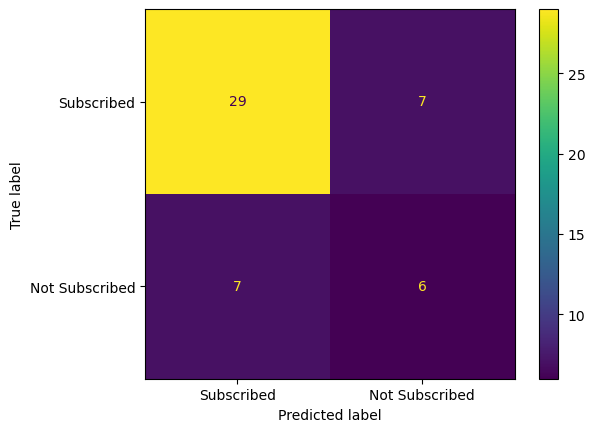

In [111]:
conf_mat = confusion_matrix(y_test, y_pred, labels=[True, False])
conf_mat_disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=["Subscribed", "Not Subscribed"]
)

conf_mat_disp.plot();

Figure 13: Confusion Matrix of Highest-Performing Classifier

Looking at the confusion matrix, we see an equal balance between precision and recall. It's interesting to note that if precision is of primary importance, our classifier actually significantly outperforms the majority-class classifier:

In [112]:
precision_score(y_test, y_pred)

np.float64(0.8055555555555556)

(Recall that the majority-class classifier has precision equal to its accuracy—73% in this case.)

Why did our best classifier fail to beat the majority-class classifier? We saw some extremely strong associations with subscription status in our data exploration: why didn't those help us? The answer is that while there are very strong signals in our data, those signals are only present in a small proportion of players. The majority of players have very weak signals of subscription status, and there isn't much KNN can do to pick up on them.

It isn't just a matter of the stronger signals of more active players dominating the weaker signals of less active ones. We can attempt to "amplify" the weaker signals by removing all active players from the data and re-running the analysis. You can do this by adding

`players_combined = players_combined[players_combined["num_sessions"] < 2]`

at the end of the "Tidying and initial wrangling" section and re-running the notebook. You'll see that the model only performs marginally better under these artificial conditions.

It's worth considering whether a different classification method would have yielded better results, but that is beyond the scope of this report.

#### The most-predictive features

We'll now look at the features the best perfoming classifier used:

In [113]:
grid.best_params_["select__columns"]

['gender_disclosure_status',
 'num_sessions',
 'avg_session_length_seconds',
 'age']

For the numerical features, we can look at how they relate to each other with the following pair plots. Note that in order for the subplots to have reasonable scales, we remove extreme points (age more than 50, number of sessions more than 30).

In [114]:
# Remove extreme points for plotting and change column names to have nice names
# for axes titles (unfortunately we can't look up titles dynamically for pair
# plots in Altair)
df_train_final_temp = df_train_final[
    (df_train_final["age"] <= 50) & (df_train_final["num_sessions"] <= 30)
].rename(
    columns={
        "num_sessions": "Number of Sessions",
        "avg_session_length_seconds": "Average session length (seconds)",
        "age": "Age",
    }
)
columns_to_plot = ["Number of Sessions", "Average session length (seconds)", "Age"]

quant_features_pair_plots = (
    alt.Chart(df_train_final_temp)
    .mark_point(opacity=0.6)
    .encode(
        alt.X(alt.repeat("row"), type="quantitative"),
        alt.Y(alt.repeat("column"), type="quantitative"),
        color=alt.Color("subscribe_label").title("Subscription status"),
    )
    .properties()
    .repeat(column=columns_to_plot, row=columns_to_plot)
)
quant_features_pair_plots

alt.RepeatChart(...)

Figure 14: Pair Plots of Chosen Numerical Features

There do not appear to be any obvious pairwise interactions which help us predict subscription status among the numerical features.

To finish our analysis, we'll summarize the features chosen along with the strength of the association they have with subscription status (as determined in our data exploration):

+ **gender disclosure status**: strong association
+ **number of gameplay sessions**: strong association
+ **average session length**: moderate association
+ **age**: weak association

Note that gameplay hours was not selected in the grid search as a predictor feature. We hypothesize this was due to gameplay hours and number of sessions encoding mostly the same information and number of sessions being the more predictive variable of the two.

## Discussion

We have found that we can best predict whether PLAIcraft players have subscribed to the newsletter by considering:

+ **Age**: younger players are more likely to subscribe
+ **Average session length**: players with longer sessions are more likely to subscribe
+ **Gender disclosure**: players who have declared their gender are much more likely to subscribe
+ **Number of sessions played**: players with more sessions are much more likely to subscribe

While these features—particularly number of sessions and average session length—can be extremely strong predictors for some players, they only weakly predict subscription status for the majority of players.

The actual features chosen by the best-performing classifier and the direction of their relationship with subscription status seem reasonable. However, we felt it was surprising how poorly these features predicted subscription status for most players. We suspect other factors not in the data driving whether a player subscribes to the newsletter.

While our report provides a reasonable answer to Frank Wood's question, the greater impact of our report is to highlight issues with the data and with the features that are being collected. We identify questions for future work to address: (1) Why were there discrepancies in the data? Do the discrepancies have a significant impact on our findings in this report? (2) What additional features do we need to collect for the data that would be more useful for predicting newsletter subscription status?